# Posterior Predictive Checks

PPCs are a great way to validate a model. The idea is to generate data sets from the model using parameter settings from draws from the posterior. 

Elaborating slightly one can say that - Posterior predictive checks (PPCs) analyze the degree to which data generated from the model deviate from data generated from the true distribution. So often you'll want to know if for example your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a 'sense check' or explaining your model to others and getting criticism. 


`PyMC3` has random number support thanks to [Mark Wibrow](https://github.com/mwibrow) as implemented in [PR784](https://github.com/pymc-devs/pymc3/pull/784).

Here we will implement a general routine to draw samples from the observed nodes of a model.

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

Lets generate a very simple model:

In [2]:
data = np.random.randn(100)

with pm.Model() as model: 
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data)
    
    trace = pm.sample_init()

Applied log-transform to sd and added transformed sd_log_ to model.
Initializing using advi...


Iteration 0 [0%]: ELBO = -664.2
Iteration 50000 [10%]: Average ELBO = -163.37
Iteration 100000 [20%]: Average ELBO = -136.07
Iteration 150000 [30%]: Average ELBO = -136.07
Iteration 200000 [40%]: Average ELBO = -136.06
Iteration 250000 [50%]: Average ELBO = -136.07
Iteration 300000 [60%]: Average ELBO = -136.07
Iteration 350000 [70%]: Average ELBO = -136.07
Iteration 400000 [80%]: Average ELBO = -136.07
Iteration 450000 [90%]: Average ELBO = -136.07


Sampling using nuts...


Finished [100%]: Average ELBO = -136.07


100%|██████████| 2000/2000 [00:00<00:00, 2999.98it/s]


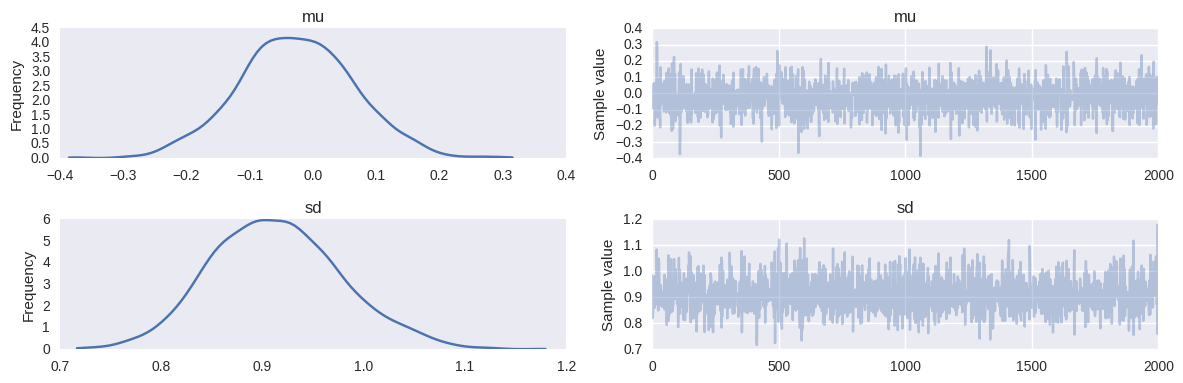

In [3]:
pm.traceplot(trace);

This function will randomly draw 50 samples of parameters from the trace. Then, for each sample, it will draw 100 random numbers from a normal distribution specified by the values of `mu` and `std` in that sample.

In [4]:
ppc = pm.sample_ppc(trace, samples=500, model=model, size=100)

100%|██████████| 500/500 [00:03<00:00, 147.41it/s]


Now, `ppc` contains 500 generated data sets (containing 100 samples each), each using a different parameter setting from the posterior:

In [5]:
np.asarray(ppc['n']).shape

(500, 100)

One common way to visualize is to look if the model can reproduce the patterns observed in the real data. For example, how close are the inferred means to the actual sample mean:

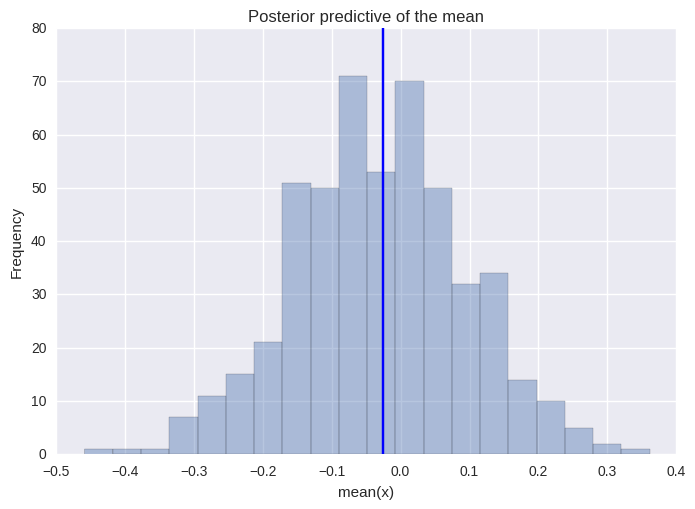

In [6]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc['n']], kde=False, ax=ax)
ax.axvline(data.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

## Comparison between PPC and other model evaluation methods. 

An excellent introduction to this is given on [Edward](http://edwardlib.org/tutorials/ppc) and since I can't write this any better I'll just quote this:

"PPCs are an excellent tool for revising models, simplifying or expanding the current model as one examines how well it fits the data. They are inspired by prior checks and classical hypothesis testing, under the philosophy that models should be criticized under the frequentist perspective of large sample assessment.

PPCs can also be applied to tasks such as hypothesis testing, model comparison, model selection, and model averaging. It’s important to note that while they can be applied as a form of Bayesian hypothesis testing, hypothesis testing is generally not recommended: binary decision making from a single test is not as common a use case as one might believe. We recommend performing many PPCs to get a holistic understanding of the model fit." 

An important lesson to learn as someone using Probabilistic Programming is to not overfit your understanding or your criticism of models to only one metric. Model evaluation is a skill that can be honed with practice. 



## Prediction

The same pattern can be used for prediction. Here we're building a logistic regression model. Note that since we're dealing the full posterior, we're also getting uncertainty in our predictions for free.

In [16]:
# Use a theano shared variable to be able to exchange the data the model runs on
from theano import shared

In [17]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

n = 4000
n_oos = 50
coeff = 1.

predictors = np.random.normal(size=n)
# Turn predictor into a shared var so that we can change it later
predictors_shared = shared(predictors)

outcomes = np.random.binomial(1, invlogit(coeff * predictors))

In [18]:
outcomes

array([0, 0, 0, ..., 1, 0, 0])

In [19]:
predictors_oos = np.random.normal(size=50)
outcomes_oos = np.random.binomial(1, invlogit(coeff * predictors_oos))

In [20]:
def tinvlogit(x):
    import theano.tensor as t
    return t.exp(x) / (1 + t.exp(x))

with pm.Model() as model:
    coeff = pm.Normal('coeff', mu=0, sd=1)
    p = tinvlogit(coeff * predictors_shared)

    o = pm.Bernoulli('o', p, observed=outcomes)
    
    trace = pm.sample_init(n_init=5000)

Initializing using advi...


Iteration 0 [0%]: ELBO = -2436.2
Iteration 500 [10%]: Average ELBO = -3080.73
Iteration 1000 [20%]: Average ELBO = -2944.81
Iteration 1500 [30%]: Average ELBO = -2832.08
Iteration 2000 [40%]: Average ELBO = -2712.6
Iteration 2500 [50%]: Average ELBO = -2663.06
Iteration 3000 [60%]: Average ELBO = -2553.8
Iteration 3500 [70%]: Average ELBO = -2502.3
Iteration 4000 [80%]: Average ELBO = -2456.67


Sampling using nuts...


Iteration 4500 [90%]: Average ELBO = -2440.13
Finished [100%]: Average ELBO = -2408.58


100%|██████████| 2000/2000 [00:11<00:00, 180.17it/s]


In [21]:
# Changing values here will also change values in the model
predictors_shared.set_value(predictors_oos)

In [22]:
# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(trace, model=model, samples=500)

100%|██████████| 500/500 [00:02<00:00, 189.51it/s]


### Mean predicted values plus error bars to give sense of uncertainty in prediction

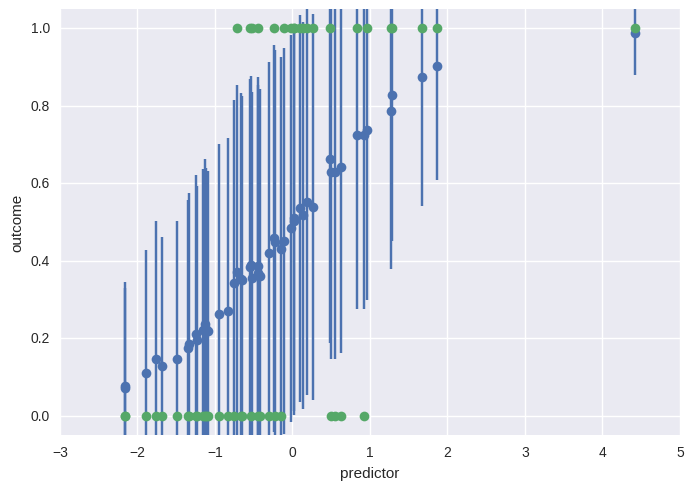

In [23]:
plt.errorbar(x=predictors_oos, y=np.asarray(ppc['o']).mean(axis=0), yerr=np.asarray(ppc['o']).std(axis=0), linestyle='', marker='o')
plt.plot(predictors_oos, outcomes_oos, 'o')
plt.ylim(-.05, 1.05)
plt.xlabel('predictor')
plt.ylabel('outcome')